## Multilayer Perceptron In TensorFlow

Lets now construct the multilayer perceptron

<img width=400px src="http://i63.tinypic.com/inv0b9.png">

This is in principle no different, we just need to add in another perceptron layer. Notice that a single perceptron layer is just a the following matrix transform:

$$
\sigma(X^T \mathbf{W}_i + \mathbf{b}) = \sigma\left (\,\,\left(\begin{matrix} x_1 \\ x_2 \end{matrix}\right)
\left(\begin{matrix} w_{11} & w_{12} \\ w_{21} & w_{22} \end{matrix}\right) + \left(\begin{matrix} b_1 \\ b_2 \end{matrix}\right)\,\,\right)
$$

This gives us a cleaner way to build the network. 

In the code below, I will carefully build the multilayer perceptron network, documenting each step. The network will be composed of four layers and an optimizer. The layers are distributed as follows:

* __Input__: The input layer containing the placeholders for $X$ and $Y$. We assume $Y$ is in a one hot encoding, so `NUM_LABELS` will be 2. Furthermore, specifying `None` for axis 0 of the input shape allows TensorFlow to decide the vector length at runtime based on the size of the batch passed. 
* __Layer1__: Layer 1 computes $\mathbf{X}\mathbf{W}_1 + b_1$ where $\mathbf{W}_1$ is a $2\times N1$ matrix and $b$ is a $N1$ vector. We use a sigmoid $\sigma$ activation function to mimic the step function of the perceptron. We save the output in $\mathbf{Z}_1$. 
* __Layer2__: Layer 2 computes $\mathbf{Z}_1\mathbf{W}_2 + b_2$ where $\mathbf{W}_2$ is a $N1\times 2$ matrix and $b_2$ is a 2 vector. We again use a sigmoid $\sigma$ activation function to mimic the step function of the perceptron. We save the output in $O$. 
* __Loss__: We compute the softmax cross entropy with logits. __Softmax__ normalizes the vector $O$ into a probability vector, so the entries sum to 1. __Cross entropy__ is minus log of the probability then guessed for the correct label. 
* __Optimizer__: For training, we need to add an optimizer. In this case we use `tf.train.GradientDescentOptimizer` and let TensorFlow do the work of backpropagation for us. We then set `training_op` to minimize the result of the loss computed above. 

Finally, we add the global variable initializer. 

In [1100]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

reset_graph()

NUM_FEATURES = 2
NUM_LABELS = 2
NUM_EPOCHS = 20
LEARNING_RATE = .01
BATCH_SIZE = 2
N = 4
N_BATCHES = N/BATCH_SIZE

N1 = 4  # Number of nodes in first perceptron layer

## Set up the function to train    
X = tf.placeholder(tf.float32, shape=(None,NUM_FEATURES))  ## Adjust to batch size
Y = tf.placeholder(tf.float32, shape=(None,NUM_LABELS))  ## Adjust to batch sise

## Layer 1
with tf.name_scope("Layer1"):
    W1 = tf.Variable(tf.random_normal([NUM_FEATURES, N1]), tf.float32)
    B1 = tf.Variable(tf.random_normal([1, N1]), tf.float32)
    Z1 = tf.nn.sigmoid(tf.matmul(X,W1)+ B1)

## Layer 2
with tf.name_scope("Layer2"):
    W2 = tf.Variable(tf.random_normal([N1, NUM_LABELS]), tf.float32)
    B2 = tf.Variable(tf.random_normal([1, NUM_LABELS]), tf.float32)
    O = tf.nn.sigmoid(tf.matmul(Z1,W2)+ B2)

with tf.name_scope("Loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=O)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("Optimize"):   
    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    training_op = optimizer.minimize(loss) 

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now, we actually train the network. 

* __Setup__: We initialize the training data to either the XOR or AND distribution. We also set up a $20\times 20$ grid to check the result of our fit.

* __Initializing__: Inside a session, initialize our graph variable and output a summary of the network to the `./graphs` folder (note: uncomment this line if you to view the graph structure in TensorBoard). We redefine the data in case it has gotten overwritten at some point. 

* __Training:__ For each epoch, we generate a random permutation of the indices of the training data. We then loop through the indices, feeding a single instance of `X` and `Y` into the network. Note, we must reshape because Python drops the first dimension for single instances. 

* __Remember: We are not saving the weights, so each time you close the session the graph's weights will be reset.__

* __Output:__ Within the same session, we output the contents of the weight matrices. Finally, we predict the label on each element of our generated grid. Note that we must `argmax` the result to get an actual answer. Finally, we plot the resulting fitting. 

Run the code below until you get a reasonable fit. It may take a couple of tries. 

In [1101]:
## Data
x = np.array([[0, 0], [1, 0], [1, 1], [0, 1]], np.float32) 
#y = np.array([0, 0, 1, 0], np.float32) # AND distribution
y = np.array([0, 1, 0, 1], np.float32) # XOR distribution
y_d = np.array(pd.get_dummies(y), np.float32) # XOR distribution

## Generate a grid from [-10,10]x[-10,10] for us to predict on
X1, Y1 = np.meshgrid(np.linspace(-10,10),np.linspace(-10,10))
X2, Y2 = np.meshgrid(np.linspace(-.1,1.1),np.linspace(-.1,1.1))

## To predict on the grid, we must pass it to the network as a Nx2 vector
Z1 = np.concatenate([X1.reshape(-1,1),Y1.reshape(-1,1)],axis=1) 
Z2 = np.concatenate([X1.reshape(-1,1),Y1.reshape(-1,1)],axis=1) 


NUM_EPOCHS = 500
with tf.Session() as sess:
    init.run()
#    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    for epoch in range(NUM_EPOCHS):
        for i in np.random.permutation(4):
            sess.run(training_op, feed_dict={X:x[i].reshape(1,-1),Y:y_d[i].reshape(-1,2)})
    
    ## Report Weights
    print("The weights W1:\n",sess.run(W1))
    print("The weights B1:\n",sess.run(B1))
    print("The weights W2:\n",sess.run(W2))
    print("The weights B2:\n",sess.run(B2))
    
    ## Predict on the grid
    Y_hat1 = O.eval(feed_dict={X: Z1})
    Y_hat2 = O.eval(feed_dict={X: Z2})

The weights W1:
 [[ 1.0686092  -2.474807   -1.621447   -0.36433503]
 [ 0.39524555  0.26563856  0.99114347 -0.3480598 ]]
The weights B1:
 [[ 0.06373418 -1.0183132  -0.24104863 -0.3632297 ]]
The weights W2:
 [[-1.0978028  -1.4918492 ]
 [-0.3578859   0.21201748]
 [-1.670143   -0.73276114]
 [-0.3462435   0.89198697]]
The weights B2:
 [[1.0676625  0.60627997]]


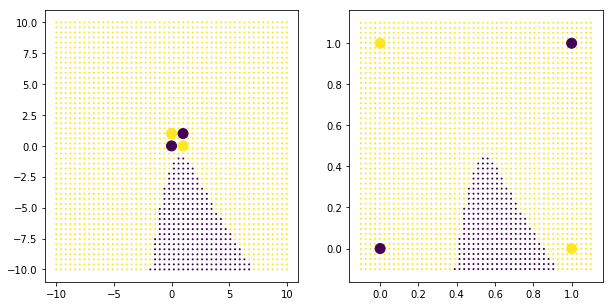

In [40]:
## Reshape prediction back to grid
Y_hat_p1 = np.argmax(Y_hat1,axis=1).reshape(50,50)
Y_hat_p2 = np.argmax(Y_hat2,axis=1).reshape(50,50)

## Plot predicted classifier
f, axes = plt.subplots(1,2,figsize = (10,5))
axes[0].scatter(X1, Y1, c=Y_hat_p1, s=1, cmap='viridis')
axes[0].scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=100, cmap='viridis')

axes[1].scatter(X2, Y2, c=Y_hat_p2, s=1, cmap='viridis')
axes[1].scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=100, cmap='viridis')

## Question:

One reason the code above doesn't always return a good fit despite the fact that a theoretical fit exists is that we are not using the hard step function. Change the code above to try to find a network that has a high probability of correctly fitting the XOR distribution across multiple runs. 

Some things you can change:

* The number of epochs.
* The learning rate.
* The layer sizes.
* More layers.
* Initialization of the weights is marks the starting point for training, and so is hugely important. Try using `tf.zeros`, `tf.ones` or `tf.random_normal(,stdev=.1)` to initialize the weights. 
* What happens if you use ReLU or tanh instead of the sigmoid activation function?
* Try adding an `optimize2` and `optimize3` node with different learning rates. This will allow you to create a __learning schedule__.

## Question:

Construct a perceptron network with at least 3 layers and add a jump connection between layers 1 and 3 to increase training speed. A jump connection is a direct pipe from Layer 1 to to Layer 3, bypassing Layer 2. Such connection can greatly speed up training on very deep, very wide networks by first training the rough structure of the jump network and then fine tuning with the intermediate layers.  

## Question:

Why is it generally preferable to use a Logistic Regression classifier rather than a classical Perceptron (i.e., a single layer of linear threshold units trained using the Perceptron training algorithm)? How can you tweak a Perceptron to make it equivalent to a Logistic Regression classifier?

## Bonus Question:

Write a perceptron for classifying the MNIST dataset with at least two deep layers. 